In [2]:
import plotly
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
import matplotlib.animation as animation
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.lines import Line2D
from scipy.signal import fftconvolve
from sklearn.svm import LinearSVC
from itertools import *
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn import linear_model

!git clone https://github.com/HNinou/MathTools_TD2
!unzip MathTools_TD2/dic_cont8_GO.npy.zip -d MathTools_TD2/

Cloning into 'MathTools_TD2'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 16.96 MiB | 36.33 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Archive:  MathTools_TD2/dic_cont8_GO.npy.zip
  inflating: MathTools_TD2/dic_cont8_GO.npy  
  inflating: MathTools_TD2/__MACOSX/._dic_cont8_GO.npy  


# Performing PCA on neural data


In [3]:
def gaussian(x, sigma, mu=0):
    return np.exp(-((x-mu)**2) / (2*sigma**2))

def make_conv_kernel( sigma= 30):
    nb_time_frames = 6*sigma
    conv_kernel = gaussian(np.arange(-nb_time_frames//2,nb_time_frames//2,1), sigma=sigma)
    conv_kernel /= np.sum(conv_kernel)

    return conv_kernel

def smoothen_data(dic, sigma=30):
    # Get number of neurons
    nb_neurons = len(dic['mat'])

    # Create the convolution kernel
    conv_kernel = make_conv_kernel(sigma=sigma)

    # Pre-allocate the smooth_mat with the same structure as dic['mat']
    smooth_mat = [None] * nb_neurons

    # Loop over neurons, but vectorize across trials
    for neuron in range(nb_neurons):
        # Get all trials for this neuron as a 2D matrix (nb_trials, time_points)
        mat_neuron = dic['mat'][neuron]

        # Use fftconvolve for faster convolution across all trials
        smooth_neuron = fftconvolve(mat_neuron, conv_kernel[None, :], mode='same', axes=1)

        # Store the result back
        smooth_mat[neuron] = smooth_neuron

    # Replace the original matrix with the smoothed data
    dic['sm_mat'] = smooth_mat
    return dic


def raster_plot(neural_data):
  # Create the raster plot using Plotly
  fig = go.Figure(data=go.Heatmap(
      z=neural_data,
      colorscale='Greys',
      colorbar=dict(
          title="Neural Activity",
          titleside='right',
          ticks='outside',
          ticklen=5,
          tickcolor='black',
      )
  ))

  fig.update_layout(
      title="Neural Activity Raster Plot",
      xaxis=dict(
          title="Time (ms)",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      yaxis=dict(
          title="Trial Index",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      plot_bgcolor='white',
      font=dict(size=14),
  )

  # Display the plot
  fig.show()
  return()

The cell below stores the data in the dictionnary dic_cont8. The raw data is stored in dic_cont8['mat'] which is a list of size 777, that is the total number of neurons. Each element of this list contains a matrix of size (#trials x #timesteps). For each recording, that is for each trial, the data is shifted so that the 'GO' signal always shows up at the 2000th time frame.

In [4]:
# Load the data from the .npy files

centering = 'GO'
dic_cont8 =np.load('MathTools_TD2/dic_cont8_GO.npy', allow_pickle = True).flat[0]
# Smooth the data using a Gaussian filter with a sigma of 100
dic_cont8 = smoothen_data(dic_cont8, sigma=100)

nb_neurons = len(dic_cont8['target'])

nb_trials_cont8 = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_cont8[i] = dic_cont8['target'][i].shape[0]

In [5]:
nb_neurons= len(dic_cont8['mat'])
nb_trials = []
for n in range(nb_neurons):
    nb_trials.append(dic_cont8['mat'][n].shape[0])
nb_trials = np.array(nb_trials)


Let's store the number of trials per neuron for each of the 8 targets

In [6]:
nb_neurons= len(dic_cont8['mat'])
nb_trials_per_c = np.zeros((8,nb_neurons))
for k,target in enumerate(range(1,9)):
  for n in range(nb_neurons):
    nb_trials_per_c[k, n] = dic_cont8['mat'][n][dic_cont8['target'][n]==target].shape[0]


# 1)


In [7]:
neuron_filter_ct = np.zeros(nb_neurons) == 0

for n in range(nb_neurons):
  for target in range(1,9):
    if (dic_cont8['target'][n] == target).sum() < 20 :
        neuron_filter_ct[n] = False

In [8]:
neuron_filter_ct.sum()

245

There are 245 neurons fulfilling this condition.

In [9]:
# put the 10 first trials in the training set and the 2 last in the testing set

X = []
for n in range(nb_neurons):
    if neuron_filter_ct[n]:
        res = []
        for target in range(1,9):
            filter_res = np.where(dic_cont8['target'][n] == target)[0][:20]
            res.append(dic_cont8['sm_mat'][n][filter_res][:,1700:1701].mean(axis = 0).flatten())

        res = np.array(res)

        X.append(res.flatten())


X = np.array(X)

X -= X.mean(axis = 1)[:,None]

In [10]:
C = X@X.T/neuron_filter_ct.sum()
eigval, eigvec = np.linalg.eigh(C)

In [11]:
colors = np.zeros(400*8)
for target in range(8):
    colors[target:(target+1)] = target/7

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec[:,-1]  @ X),
    y=(eigvec[:,-2]  @ X),
    z=(eigvec[:,-3]  @ X),
    mode='markers',
    marker=dict(size = 10,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


## c) The neural states are disntinct


Variance explained by the 3 first PCs ?

In [12]:
eigval[-3:].sum()/eigval.sum()

0.9115596642605297

The 3 first PCs explain 91% of the variance.

# 2)



## a) targets (Y): the 8 targets but in angle (so in degrees: a circle divided by the 8 targets)
##  predictors: preparatory activity (X) the neural activity recorded 300ms before the GO cue.


## -
## b) model coefficients verify this equation: XTXβ = XTY

# 3)
## a) solve this equation: 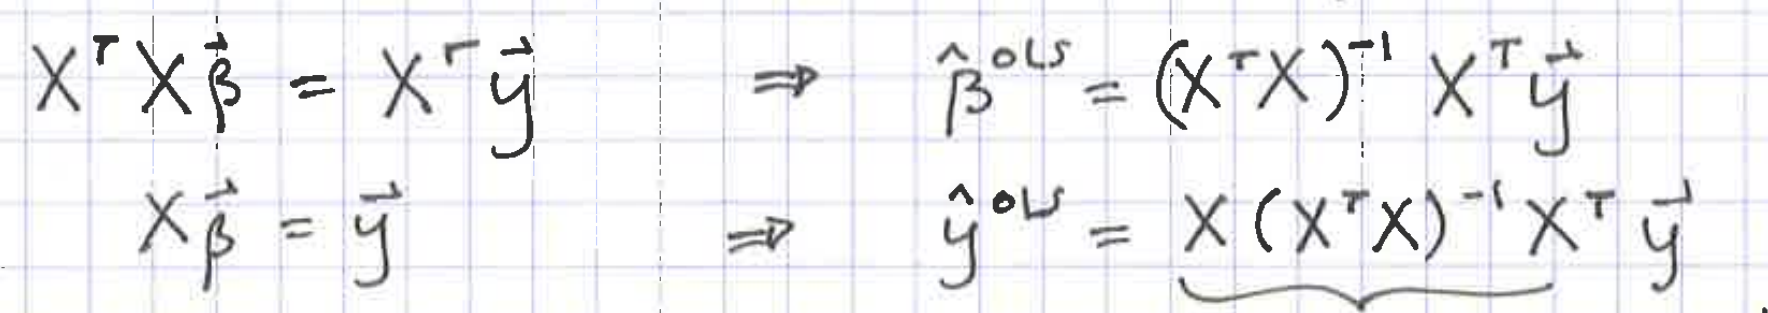

The cells below formats our data to build the targets and predictors of the training and testing sets.

In [13]:
nb_trials_train = 16
nb_trials_test = 4
nb_valid_neurons = 245
t_start = 1700
t_end = 1701

In [14]:
def get_XY_train_test():

    # put the 16 first trials in the training set and the 4 last in the testing set

    X_train = []
    X_test = []
    for n in range(nb_neurons):
        if neuron_filter_ct[n]:
            res_train = []
            res_test = []
            for target in range(1,9):
                #Get all indices for the current target
                target_indices = np.where(dic_cont8['target'][n] == target)[0]

                # Perform a train-test split to get 16 training and 4 testing trials
                train_indices, test_indices = train_test_split(target_indices, test_size=4, train_size=16)

                # Append the corresponding data slices for training and testing
                res_train.append(dic_cont8['sm_mat'][n][train_indices][:, t_start:t_end])
                res_test.append(dic_cont8['sm_mat'][n][test_indices][:, t_start:t_end])


            res_train = np.array(res_train)
            res_test = np.array(res_test)

            X_train.append(res_train)
            X_test.append(res_test)


    X_train = np.array(X_train)
    X_test = np.array(X_test)

    X_train -= X_train.reshape((nb_valid_neurons,-1)).mean(axis =1)[:,None,None,None]
    X_test -= X_test.reshape((nb_valid_neurons,-1)).mean(axis =1)[:,None,None,None]

    X_train = X_train.swapaxes(0,2)
    X_train = X_train.swapaxes(0,1)
    X_train = X_train.reshape((8*nb_trials_train, nb_valid_neurons*(t_start-t_end)))

    X_test = X_test.swapaxes(0,2)
    X_test = X_test.swapaxes(0,1)
    X_test = X_test.reshape((8*nb_trials_test, nb_valid_neurons*(t_start-t_end)))

    Y1 = np.cos( np.arange(8)[:,None] * np.ones(nb_trials_train) * 2*np.pi/8).reshape(8*nb_trials_train)
    Y2 = np.sin( np.arange(8)[:,None] * np.ones(nb_trials_train) * 2*np.pi/8).reshape(8*nb_trials_train)
    Y_train = np.column_stack((Y1,Y2))

    Y1_test = np.cos( np.arange(8)[:,None] * np.ones(nb_trials_test) * 2*np.pi/8).reshape(8*nb_trials_test)
    Y2_test = np.sin( np.arange(8)[:,None] * np.ones(nb_trials_test) * 2*np.pi/8).reshape(8*nb_trials_test)
    Y_test = np.column_stack((Y1_test,Y2_test))

    return X_train, X_test, Y_train, Y_test


In [15]:
X_train, X_test, Y_train, Y_test = get_XY_train_test()

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)


(128, 245) (32, 245)
(128, 2) (32, 2)


# 4)

In [16]:
#(XTX)-1 @ XTX

XTX = X_train.T@X_train
inv_mat = np.linalg.inv(XTX)



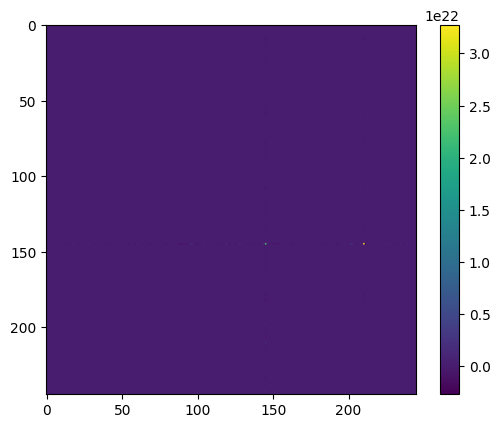

In [17]:
plt.imshow(inv_mat)
plt.colorbar()

# 4 b) issue : no correlation at all, because XTX is not invertible directly: use the pseudoinverse

## 5) use the pseudoinverse, X (XTX)-1 XT, and do regression !

# 6) By adding constant $ \delta $ to the diagonal:  XT X → XT X + $\delta$ I . This is the essentially ridge regression

# 7)

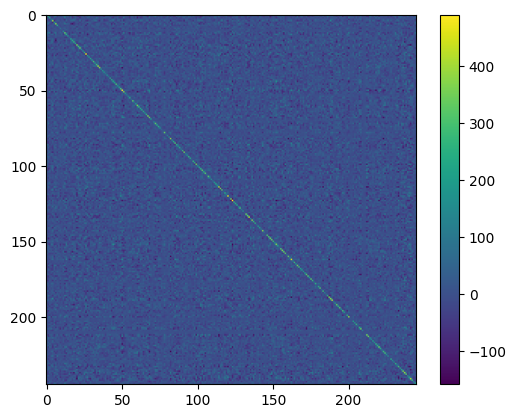

In [18]:
pinv_mat = np.linalg.pinv(X_train.T@X_train)
plt.imshow(pinv_mat)
plt.colorbar()

From now on, we will use the built in functions from scikit learn to implement our models.
The cell below builds a linear regression model with biases and fits the coefficients to the training data.

In [19]:
linreg_model = linear_model.LinearRegression(fit_intercept=True)
linreg_model.fit(X_train, Y_train)

LinearRegression()

The cell below evaluates the performance of the learned model on the test data.

In [20]:
linreg_model.score(X_test, Y_test)

0.8934391667204782

In [21]:
def targ_to_degrees(Y):

  rad = np.arctan2(Y[:, 1], Y[:, 0])

  #  shift to range [0, 360)
  degrees = (np.degrees(rad) + 360) % 360

  return degrees

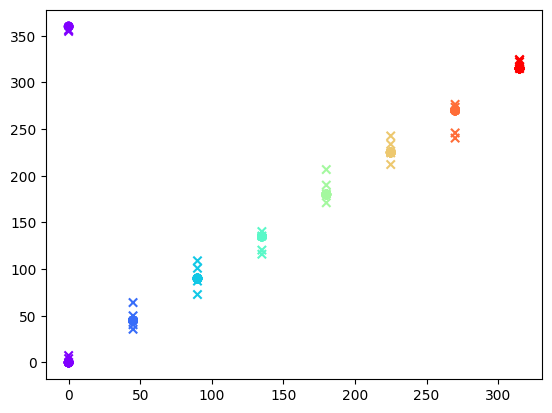

In [22]:
colors_train = (np.arange(8)[:,None]*np.ones(nb_trials_train)).reshape(8*nb_trials_train)
colors_test =  (np.arange(8)[:,None]*np.ones(nb_trials_test)).reshape(8*nb_trials_test)


Y_train_predicted = linreg_model.predict(X_train)
Y_test_predicted = linreg_model.predict(X_test)



plt.scatter(targ_to_degrees(Y_train), targ_to_degrees(Y_train_predicted), c = colors_train, cmap = 'rainbow')
plt.scatter(targ_to_degrees(Y_test), targ_to_degrees(Y_test_predicted), c = colors_test, cmap = 'rainbow', marker = 'x')


# 7 b) it seems it captures the train data better (almost perfect diagonal), the residual distance is larger for the test set: the points scatter much more around the diagonal (fails to generalise fully).

# 8) increasing α  decreases large coefficients, so decreases complexity (higher penalty, which shrinks the coefficients).

# 9)

In [23]:
from sklearn.model_selection import KFold

def kfold_evaluation(model, features, targets, splits=8):
    kf = KFold(n_splits=splits, shuffle=True)
    evaluation_scores = []

    for train_indices, val_indices in kf.split(features):
        train_features, val_features = features[train_indices], features[val_indices]
        train_targets, val_targets = targets[train_indices], targets[val_indices]

        model.fit(train_features, train_targets)
        score = model.score(val_features, val_targets)
        evaluation_scores.append(score)

    return evaluation_scores

# Initialize an array to store the mean scores for each iteration
score_linreg = np.zeros(100)

# Run the KFold evaluation 100 times
for iteration in range(100):
    regression_model = linear_model.LinearRegression(fit_intercept=True)
    fold_scores = kfold_evaluation(regression_model, X_train, Y_train, splits=5)
    score_linreg[iteration] = np.mean(fold_scores)


score_linreg.mean()

0.8566080036942916

# 10)

This can take a while

In [24]:

from sklearn.linear_model import Ridge

alpha_list = np.logspace(-6, -1, 50)
score_ridge = np.zeros((100,50))

for alpha in alpha_list:
  for i in range(100):
    scores = kfold_evaluation(Ridge(alpha=alpha, fit_intercept=True), X_train, Y_train, splits=5)
    score_ridge[i,np.where(alpha_list == alpha)] = np.mean(scores)

# 11)

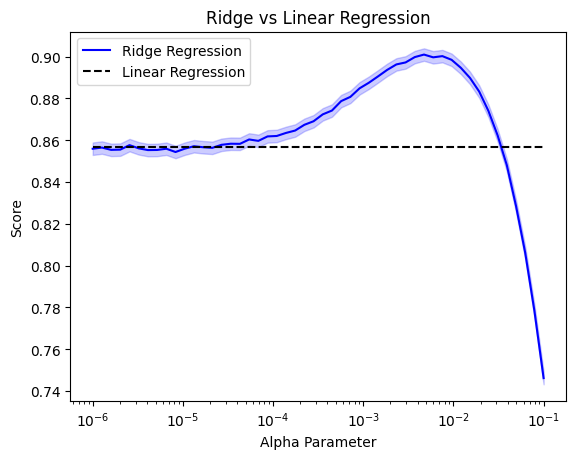

In [25]:
# Compute means and standard errors
ridge_mean = score_ridge.mean(axis = 0)
ridge_sem = score_ridge.std() / np.sqrt(score_ridge.shape[0])
linreg_mean = score_linreg.mean()

# Plot Ridge Regression with shaded error area
plt.plot(alpha_list, ridge_mean, label='Ridge Regression', color='blue')
plt.fill_between(alpha_list, ridge_mean - ridge_sem, ridge_mean + ridge_sem, color='blue', alpha=0.2)

# Plot Linear Regression as a horizontal line
plt.hlines(y=linreg_mean, xmin=alpha_list[0], xmax=alpha_list[-1], color='black', linestyle='--', label='Linear Regression')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels, legend, and show the plot
plt.xlabel("Alpha Parameter")
plt.ylabel("Score")
plt.legend()
plt.title("Ridge vs Linear Regression")
plt.show()

# 12)

In [26]:
opt_alpha = alpha_list[np.argmax(ridge_mean)]
print('optimal alpha = ', opt_alpha)

optimal alpha =  0.004714866363457394


In [27]:
X_train, X_test, Y_train, Y_test = get_XY_train_test()
ridge_model = Ridge(alpha=opt_alpha, fit_intercept=True)
ridge_model.fit(X_train, Y_train)




Y_train_predicted = ridge_model.predict(X_train)
Y_test_predicted = ridge_model.predict(X_test)

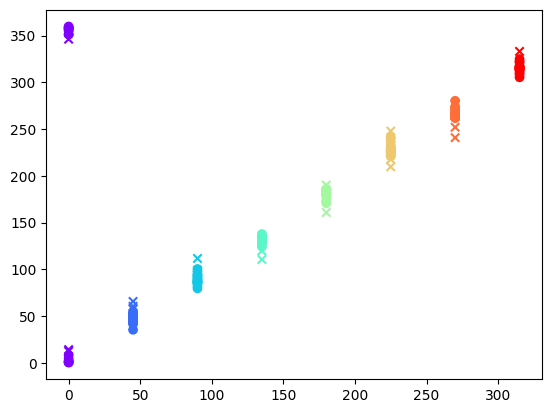

In [28]:
colors_train = (np.arange(8)[:,None]*np.ones(nb_trials_train)).reshape(8*nb_trials_train)
colors_test =  (np.arange(8)[:,None]*np.ones(nb_trials_test)).reshape(8*nb_trials_test)


plt.scatter(targ_to_degrees(Y_train), targ_to_degrees(Y_train_predicted), c = colors_train, cmap = 'rainbow')
plt.scatter(targ_to_degrees(Y_test), targ_to_degrees(Y_test_predicted) , c = colors_test, cmap = 'rainbow', marker = 'x')

# 12 c) ridge regression is much better! much less distance to true diagonal !

# 13)

In [29]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=1e-4, fit_intercept=True)
lasso_model.fit(X_train, Y_train)

ridge_coefficients = ridge_model.coef_
lasso_coefficients = lasso_model.coef_

print("Coefficients for the Lasso regression model (alpha = 10^(-4)) : ", lasso_model.coef_)
print("Coefficients for the Ridge regression model (alpha = 10^(-4)) : ", ridge_model.coef_)

Coefficients for the Lasso regression model (alpha = 10^(-4)) :  [[  0.           0.          -0.          -0.          -0.
    0.           0.           1.85448908  -0.           0.
    0.           0.          -0.           0.           0.0654097
    0.           0.           0.          -0.           2.73505165
  -10.58472241   4.39853841  -0.          -0.          -0.
    0.           0.           0.           0.          -2.62596603
   -0.          -0.          -0.          -0.           0.
   -4.71092444  -0.          10.9469934    0.           0.
   -0.           0.           2.45413813  -6.07349373  -0.
   -0.          -0.          -0.          -1.86881612  -0.45037981
    0.           0.          -0.          -0.17845092  -0.
   -0.          -0.           1.14159316   0.           0.
   -0.          -0.           0.           0.          -3.262117
    0.           0.           0.           0.           0.
    0.           0.          -0.           1.92343058   0.
    0.       

# 13 b)  a lot of the Lasso coefs are 0, more sparse solution. Ridge shrinks coefficients but does not force them fully to reach zero.

# 14)

This can take a while

In [31]:
score_linreg = np.zeros(100)

for i in range(100):
  scores = kfold_evaluation(linear_model.LinearRegression(fit_intercept=True), X_train, Y_train, splits=5)
  score_linreg[i] = np.mean(scores)

alpha_list = np.logspace(-5, -3, 50)
score_ridge = np.zeros((100,50))

for alpha in alpha_list:
  for i in range(100):
    ridge_model = Ridge(alpha=alpha, fit_intercept=True)
    scores = kfold_evaluation(ridge_model, X_train, Y_train, splits=5)
    score_ridge[i,np.where(alpha_list == alpha)] = np.mean(scores)



alpha_lasso_list = np.logspace(-5, -3, 50)
score_lasso = np.zeros((100, 50))

for alpha in alpha_lasso_list:
    for i in range(100):
        lasso_model = Lasso(alpha=alpha, fit_intercept=True, max_iter = 10000)
        scores = kfold_evaluation(lasso_model, X_train, Y_train, splits=5)
        score_lasso[i, np.where(alpha_lasso_list == alpha)] = np.mean(scores)



In [37]:
opt_lasso_alpha = alpha_lasso_list[np.argmax(score_lasso.mean(axis=0))]

print('optimal alpha = ', opt_lasso_alpha)

optimal alpha =  0.00010481131341546853


# 15)

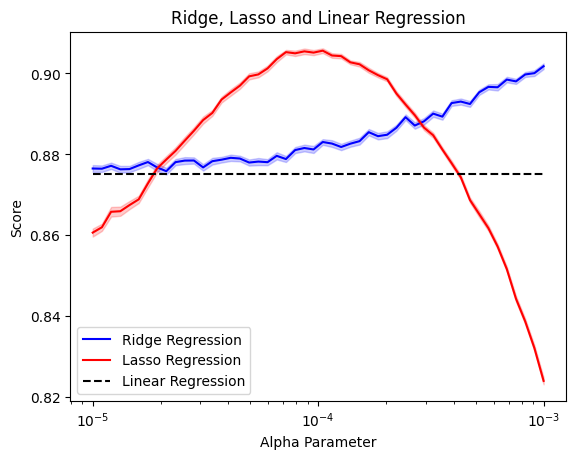

In [34]:
# Compute means and standard errors
ridge_mean = score_ridge.mean(axis=0)
ridge_sem = score_ridge.std(axis =0)/ np.sqrt(score_ridge.shape[0]) # ! this is the standard error not the STD!
lasso_mean = score_lasso.mean(axis=0)
lasso_sem = score_lasso.std(axis=0) / np.sqrt(score_lasso.shape[0]) # ! this is the standard error not the STD!
linreg_mean = score_linreg.mean()

# Plot Ridge Regression with shaded error area
plt.plot(alpha_list, ridge_mean, label='Ridge Regression', color='blue')
plt.fill_between(alpha_list, ridge_mean - ridge_sem, ridge_mean + ridge_sem, color='blue', alpha=0.2)

# Plot Lasso Regression with shaded error area
plt.plot(alpha_lasso_list, lasso_mean, label='Lasso Regression', color='red')
plt.fill_between(alpha_lasso_list, lasso_mean - lasso_sem, lasso_mean + lasso_sem, color='red', alpha=0.2)


# Plot Linear Regression as a horizontal line
plt.hlines(y=linreg_mean, xmin=alpha_list[0], xmax=alpha_list[-1], color='black', linestyle='--', label='Linear Regression')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels, legend, and show the plot
plt.xlabel("Alpha Parameter")
plt.ylabel("Score")
plt.legend()
plt.title("Ridge, Lasso and Linear Regression")
plt.show()

# 15)  Lasso has the best performance while Ridge closely follows.

# What is interesting to note is the Lasso regression drops steep after the optimal parameter, that it because the higher the α, the more 0 in the coefficients: can lead to underfitting data: sparser solution is not enough.

# Ridge Regression score increases as alpha increases, which is in accordance to the penalty so as to avoid overfitting, if alpha is too large though, it would probably underfit the model...

## *Still*, both regularization methods can exceed linear regression when  α  is well-chosen.